## **Setup**

In [1]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 1.0MB 14.3MB/s 
     |████████████████████████████████| 358kB 39.1MB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 40kB 6.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 2.6MB 44.3MB/s 


In [3]:
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.MNIST_TINY)

In [6]:
dls=ImageDataLoaders.from_folder(path,valid_pct=0.2,batch_tfms=aug_transforms(flip_vert=True, max_rotate=45.0, size=224))

In [8]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy],cbs=[ShowGraphCallback()])
learn.tta();    


epoch,train_loss,valid_loss,accuracy,time
0,1.018998,0.400851,0.859649,00:02
1,0.703050,0.380949,0.901754,00:02
2,0.516005,0.259494,0.947368,00:02
3,0.442327,0.256449,0.940351,00:02
4,0.366421,0.207952,0.954386,00:02


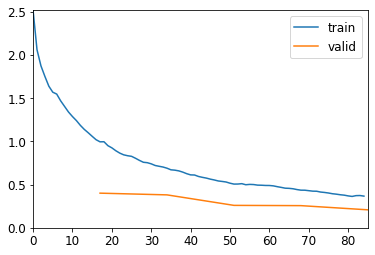

epoch,train_loss,valid_loss,accuracy,time
0,0.229408,0.228350,0.954386,00:03
1,0.228655,0.212119,0.978947,00:03
2,0.212525,0.154521,0.982456,00:03
3,0.188637,0.137271,0.978947,00:03
4,0.165731,0.143624,0.978947,00:03
5,0.144435,0.124202,0.978947,00:03
6,0.123153,0.121762,0.978947,00:03


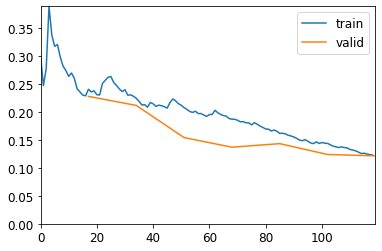

In [9]:
learn.fine_tune(freeze_epochs=5, epochs=7, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.099774,0.320828,0.908772,00:02
1,0.696535,0.498207,0.905263,00:02
2,0.541106,0.456870,0.887719,00:02
3,0.423243,0.354320,0.947368,00:02
4,0.373296,0.211083,0.961403,00:02


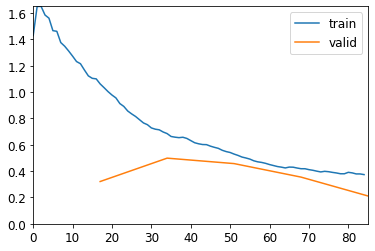

epoch,train_loss,valid_loss,accuracy,time
0,0.249972,0.229727,0.950877,00:03
1,0.227047,0.248882,0.975439,00:03
2,0.195661,0.178276,0.978947,00:03
3,0.183362,0.148482,0.968421,00:03
4,0.155731,0.138366,0.978947,00:03
5,0.143167,0.119672,0.982456,00:03
6,0.135316,0.118769,0.982456,00:03


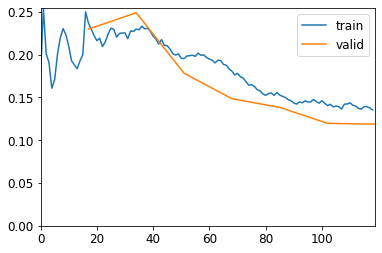

In [15]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy],cbs=[ShowGraphCallback()])
learn.fine_tune(freeze_epochs=5, epochs=7, base_lr=1e-2)

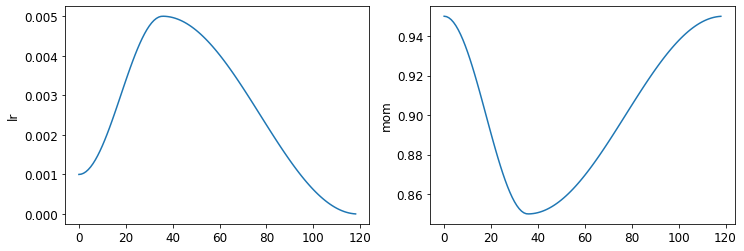

In [17]:
learn.recorder.plot_loss

In [27]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.tta(n=5)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.806377,1.331130,0.646751,02:25
1,0.820664,1.093348,0.663555,02:25
2,0.675685,1.212895,0.704630,02:25
3,0.499567,0.517825,0.846901,02:26
4,0.402300,0.423467,0.865198,02:26


In [28]:
# preds,targs = learn.tta()
accuracy(preds, targs).item()

NameError: ignored

In [ ]:
import os
import shutil
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
from zipfile import ZipFile
from tempfile import TemporaryDirectory
from PIL import Image

import cv2
from google.colab.patches import cv2_imshow
import imutils
from scipy.optimize import minimize_scalar

from sklearn.metrics import f1_score, accuracy_score

# plot options
# plt.rcParams.update({'font.size': 11})
plt.style.use('fivethirtyeight')

In [3]:
path = untar_data(URLs.IMAGENETTE)

NameError: ignored

# Functions

In [ ]:
def sqdif(bingray,sq,ang):
  rsq=imutils.resize(imutils.rotate_bound(sq,ang),width=imsz,height=imsz)

  return np.sum(np.abs(bingray-rsq))

In [ ]:
def derotate(img):
  sq=np.ones(img.shape)*255

  # binarize by blurring then using Otsu's method
  # blur=cv2.GaussianBlur(gray,(1,1),0)
  _,bingray = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  rotang=minimize_scalar(lambda ang: sqdif(bingray,sq,ang),
                         bounds=[-45,45], method='Bounded').x

  if rotang<0:
    triang=np.tan(np.pi/4+rotang*np.pi/180)
    act_x=imsz/2*(1+triang)
    act_y=imsz/2*(1-triang)

    pts1 = np.float32([[0,act_y],[act_x,0],[imsz-act_x,imsz],[imsz,imsz-act_y]])

  else:
    triang=np.tan(np.pi/4-rotang*np.pi/180)
    act_x=imsz/2*(1-triang)
    act_y=imsz/2*(1+triang)

    pts1 = np.float32([[act_x,0],[imsz,imsz-act_y],[0,act_y],[imsz-act_x,imsz]])

  pts2 = np.float32([[0,0],[imsz,0],[0,imsz],[imsz,imsz]])
  M = cv2.getPerspectiveTransform(pts1,pts2)
  
  return cv2.warpPerspective(img,M,(imsz,imsz))

In [ ]:
# SUDOKU SOLVING ALGORITHM BY PETER NORVIG https://norvig.com/sudoku.html
# slightly modified by Benjamin P Isaacoff on 8/29/20
# original code (pre-modification by BPI) taken from https://github.com/Adityaojas/sudoku-solver/blob/master/norvig.py

def cross(A, B):
  "Cross product of elements in A and elements in B."
  return [a+b for a in A for b in B]
    
digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
        [cross(r, cols) for r in rows] +
        [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) 
         for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
         for s in squares)


def test():
  "A set of unit tests."
  assert len(squares) == 81
  assert len(unitlist) == 27
  assert np.all(len(units[s]) == 3 for s in squares)
  assert np.all(len(peers[s]) == 20 for s in squares)
  assert units['C2'] == [['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
                          ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
                          ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
  assert peers['C2'] == set(['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2',
                              'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                              'A1', 'A3', 'B1', 'B3'])
  print('All tests pass.')


def parse_grid(grid):
  """Convert grid to a dict of possible values, {square: digits}, or
  return False if a contradiction is detected."""
  ## To start, every square can be any digit; then assign values from the grid.
  values = dict([(s, digits) for s in squares])
  for s,d in list(grid_values(grid).items()):
      if d in digits and not assign(values, s, d):
          return False ## (Fail if we can't assign d to square s.)
  return values

def grid_values(grid):
  "Convert grid into a dict of {square: char} with '0' or '.' for empties."
  chars = [c for c in grid if c in digits or c in '0.']
  assert len(chars) == 81
  return dict(list(zip(squares, chars)))


def assign(values, s, d):
  """Eliminate all the other values (except d) from values[s] and propagate.
  Return values, except return False if a contradiction is detected."""
  other_values = values[s].replace(d, '')
  if np.all([eliminate(values, s, d2) for d2 in other_values]):
      return values
  else:
      return False

def eliminate(values, s, d):
  """Eliminate d from values[s]; propagate when values or places <= 2.
  Return values, except return False if a contradiction is detected."""
  if d not in values[s]:
      return values ## Already eliminated
  values[s] = values[s].replace(d,'')
  ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
  if len(values[s]) == 0:
    return False ## Contradiction: removed last value
  elif len(values[s]) == 1:
      d2 = values[s]
      if not np.all([eliminate(values, s2, d2) for s2 in peers[s]]):
          return False
  ## (2) If a unit u is reduced to only one place for a value d, then put it there.
  for u in units[s]:
    dplaces = [s for s in u if d in values[s]]
    if len(dplaces) == 0:
        return False ## Contradiction: no place for this value
    elif len(dplaces) == 1:
        # d can only be in one place in unit; assign it there
          if not assign(values, dplaces[0], d):
              return False
  return values

def display(values):
  "Display these values as a 2-D grid."
  width = 1+max([len(values[s]) for s in squares])
  line = '+'.join(['-'*(width*3)]*3)
  for r in rows:
      print(''.join([values[r+c].center(width)+('|' if c in '36' else '')
                    for c in cols]))
      if r in 'CF': print(line)
  print()
    
def solve(grid):
  return search(parse_grid(grid))


def search(values):
  "Using depth-first search and propagation, try all possible values."
  if values is False:
      return False ## Failed earlier
  if np.all([len(values[s]) == 1 for s in squares]): 
      return values ## Solved!
  ## Chose the unfilled square s with the fewest possibilities
  n,s = min([(len(values[s]), s) for s in squares if len(values[s]) > 1])
  return some([search(assign(values.copy(), s, d)) for d in values[s]])

def some(seq):
  "Return some element of seq that is true."
  for e in seq:
      if e: return e
  return False


#solve("400000805030000000000700000020000060000080400000010000000603070500200000104000000")
#solve([0, 0, 0, 0, 0, 0, 8, 1, 8, 0, 0, 0, 2, 3, 0, 0, 0, 6, 0, 0, 5, 7, 0, 0, 1, 0, 7, 0, 9, 6, 0, 0, 0, 0, 0, 9, 0, 7, 0, 4, 0, 1, 0, 0, 0, 0, 0, 8, 1, 0, 4, 0, 6, 0, 0, 2, 4, 0, 0, 8, 0, 0, 4, 5, 0, 0, 9, 3, 5, 0, 0, 0, 0, 0, 0])

#parse_grid("4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......")

# Load Data

In [ ]:
# this can take a bit (maybe 30s)
# All_Data is the home directory for the images, from which training and validation splits will be taken
if not os.path.exists('/content/All_Data/'):
  os.mkdir('/content/All_Data/')
  shutil.unpack_archive(f'{mount_path}/{competition_path}/train.tar.gz','/content/All_Data/')  

In [ ]:
imgs=glob.glob('/content/All_Data/train/images/*.png')

In [ ]:
learn=load_learner(f'{mount_path}/My Drive/AI For Good - AI Blitz 3/Sudoku/Models/200829_1423_fullgennums.pkl')

In [ ]:
solutions=pd.read_csv('/content/All_Data/train/labels.csv')
solutions.head()

,id,solution
0,0,769184523521937864843652719176349258385216947492875631217593486958461372634728195
1,1,721685394683947521945312867174258639298136475356794218569873142412569783837421956
2,2,489752163235614789761398254317869425694275318528431697156947832942183576873526941
3,3,264189735351742689798356214927861453815234976436975128572493861143628597689517342
4,4,874316295652798341319254687527869413143572869986143572491635728265987134738421956


### Random image

/content/All_Data/train/images/0887.png
0887


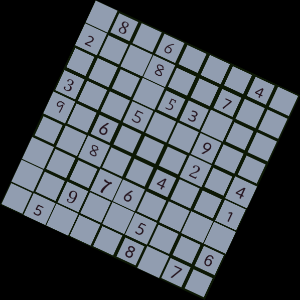

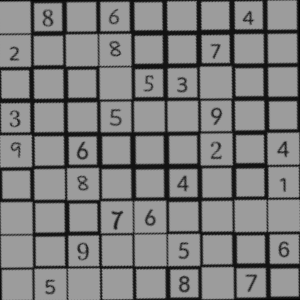

In [ ]:
impath=np.random.choice(imgs)
print(impath)
imid=os.path.basename(impath)[:-4]
print(imid)

img=cv2.imread(impath)
cv2_imshow(img)

# convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imsz = gray.shape[0]


img=derotate(gray)

cv2_imshow(img)

In [ ]:
subimgs={}
for rowind in range(9):
  for colind in range(9):
    subimgs[rowind,colind]=img[(rowind*int(imsz/9)):((rowind+1)*int(imsz/9)),
                               (colind*int(imsz/9)):((colind+1)*int(imsz/9))]

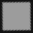

In [ ]:
cv2_imshow(subimgs[0,4])

In [ ]:
# learn.tta()

In [ ]:
learn.predict(np.stack((subimgs[0,4],)*3, axis=-1))

('blank',
 tensor(9),
 tensor([4.8852e-09, 7.5106e-10, 2.2598e-11, 1.1194e-09, 2.7796e-12, 9.0712e-12, 6.0462e-10, 7.6453e-13, 8.3095e-11, 1.0000e+00]))

blank


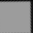

8


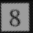

blank


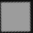

6


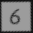

blank


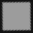

blank


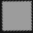

blank


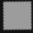

4


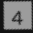

blank


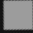

2


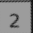

blank


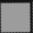

blank


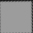

8


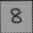

blank


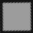

blank


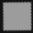

7


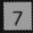

blank


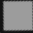

blank


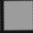

blank


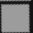

blank


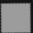

blank


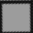

blank


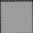

5


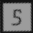

3


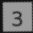

blank


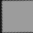

blank


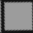

blank


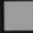

3


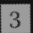

blank


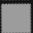

blank


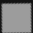

5


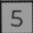

blank


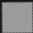

blank


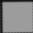

9


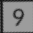

blank


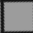

blank


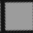

9


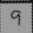

blank


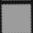

6


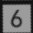

blank


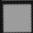

blank


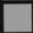

blank


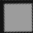

2


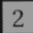

blank


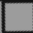

4


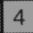

blank


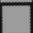

blank


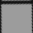

8


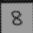

blank


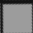

blank


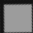

4


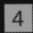

blank


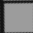

blank


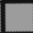

1


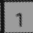

blank


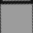

blank


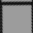

blank


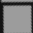

1


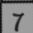

6


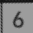

blank


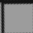

blank


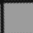

blank


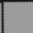

blank


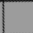

blank


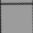

blank


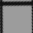

9


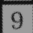

blank


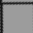

blank


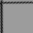

5


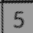

blank


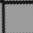

blank


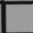

6


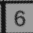

blank


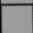

5


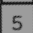

blank


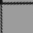

blank


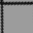

blank


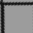

8


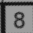

blank


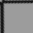

7


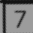

blank


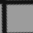

In [ ]:
curgrid=[]
for rowind in range(9):
  for colind in range(9):
    clfimg=learn.predict(np.stack((subimgs[rowind,colind],)*3, axis=-1))[0]
    
    if clfimg=='blank':
      curgrid.append('.')
    else:
      curgrid.append(clfimg)
    
    print(clfimg)
    cv2_imshow(subimgs[rowind,colind])

In [ ]:
curgrid=''.join(curgrid)

In [ ]:
curgrid

'.8.6...4.2..8..7......53...3..5..9..9.6...2.4..8..4..1...16......9..5..6.5...8.7.'

In [ ]:
solved=solve(curgrid)
solstr=''.join(solved.values())
print(solstr)

783621549265849713194753628342516987916387254578294361437162895829475136651938472


In [ ]:
solstr==solutions.loc[int(imid),'solution']

False